# INTRO 👋

[Finding Mining Sites](https://solafune.com/competitions/58406cd6-c3bb-4f7a-85c7-c5a1ad67ca03) is the ongoing challenge on Solafune. If you are a newbie to Image Classification, or perhaps dealing with images with multiple channels, this notebook will get you started. In this notebook, we'll preview the data, load in the data, train the model using FastAI 🚀, make some predictions 🤖, improve predictions 🌟, and also prepare submissions for Solafune 🏆. Let's dive in!

# The Data 📊

Looking into the data tab on Solafune, we find there are 3 files. Let's see the breakdown:

- **train.zip:** This file is about 6GB of data, containing the tif files for training the model.
- **evaluation_images.zip:** This file contains the test case images.
- **uploadsample.csv:** This CSV file is the Sample submission format that Solafune expects.

### Extras 📁:
- **train.csv:** In the Zip file of the train, you'll find this file. It is a CSV file with the filenames and their corresponding classes.

There are 1242 images in the training set, and there are 1243 images in the test set. 📸


## Requirements 🛠️

Just a basic setup: please use a GPU-enabled setup so you don't spend the whole day training the simple model 😉. I'm using Kaggle since they offer free GPUs; you can also use any other free platform you like... I guess.. 😬

###### Loading the Data 📥

There are several ways you can get your data into your environment. One easy way is for you to manually download the data and upload it into your environment. For me, I use Kaggle, and bandwidth is quite expensive, so I used Kaggle to pull in the dataset and saved it as a private Kaggle dataset. You can do the same too. All you need is this snippet of code below.

1. Open a new notebook in your Kaggle account.
2. Copy and paste the code snippet below into your notebook and run it:

```python
!wget "https://solafune-dev-v1.s3-accelerate.amazonaws.com/competitions/mining_comp/train.zip"
!wget "https://solafune-dev-v1.s3-accelerate.amazonaws.com/competitions/mining_comp/evaluation_images.zip"
!wget "https://solafune-dev-v1.s3-accelerate.amazonaws.com/competitions/mining_comp/uploadsample.csv"
```

3. The code will fetch the data and save it in your runtime.
4. Go to the data section where you will see your files
5. click on the ... to see more options, then save it as a dataset.
6. Remember to save the dataset as private, and delete it after the competition ends 😉
7. When the dataset has been saved and processed. You can add it into your kaggle environment anytime you want to work on this competition.


###### Last Thing Before You Start! 🚀

Read the description before you start coding, so you can have some insight into the challenge. Nevertheless, the challenge is to build a classification model for detecting mining sites. 🏞️💻

##### Let's Go!!!!!!!!!!! 🚀🎉

###### Setup Fastai 🚀

It's no secret anymore that I'm a big fan of the FastAI library, so we'll be using Fastai to solve this challenge. Normally, Kaggle is great in that everything you need to get started is present. However, we want our libraries updated, and to make sure we have the latest (best) of our major libraries. Below, we install FastAI and Timm. 📦🔧

# Installing Libraries 📚

### About FastAI 🚀

FastAI is an open-source deep learning library built on top of PyTorch that provides a high-level API for researchers and practitioners to build, train, and deploy machine learning models efficiently, particularly for computer vision, natural language processing, and tabular data analysis. It includes pre-trained models, data augmentation tools, and support for large datasets and distributed training.

### About Timm 📷

The Timm library is a popular open-source computer vision library built on top of PyTorch. It is created by Ross Wightman and contains a collection of SOTA (State-of-the-Art) computer vision models, layers, utilities, optimizers, schedulers, data-loaders, augmentations, and also training/validating scripts with the ability to reproduce ImageNet training results.


In [1]:
%%capture
!pip install timm
!pip install fastai

With installations out of the way, we can load in some libraries. It's good practice to keep all your imports right at the top.🔝

In [2]:
import os 
from pathlib import Path
import math
import numpy as np
from tqdm.notebook import tqdm
import rasterio 
from fastai.vision.all import *
import albumentations as A
import timm
import warnings
warnings.filterwarnings('ignore')

Import FastAI to check out your version to avoid disparities. As of the time of writing, mine was 2.7.13 📦🔍

```python
import fastai
print(fastai.__version__)


In [3]:
import fastai
print(fastai.__version__ )

2.7.13


## Taking a Look at the Data 👀

The labels come as a CSV file. For convenience and to check out the data, we can load it into a dataframe using pandas. 🐼

If you are getting an error, it means you've not uploaded the dataset into Kaggle. Or your path is incorrect. 🚨


In [4]:
datapath = "/kaggle/input/finding-mining-sites" #Change this to your own path to your dataset

In [5]:
train_df = pd.read_csv(f"{datapath}/train/answer.csv", names=["filename", "classes"])
train_df.head()

,filename,classes
0,train_0.tif,0
1,train_1.tif,0
2,train_2.tif,0
3,train_3.tif,1
4,train_4.tif,0


###### Set Seed. 

We definitely don't want to be in the shoes of those not able to reproduce their score, so let's seed everything seedable....I'm using 2024. Feel free to use the number you like. 🌐


In [6]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value)
# cpu  vars
    random.seed(seed_value)
 # Python
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
# gpu vars
        torch.backends.cudnn.deterministic = True
 #needed
        torch.backends.cudnn.benchmark = False
#Remember to use num_workers=0 when creating the DataBunch.

In [7]:
random_seed(2024,True)

###### Extra Parameters 🎨🚂

Set your preferred image size and the batch size for the training. 🖼️👥

In [8]:
# set image size
img_size = 512
# set batch size
bs = 10

## Getting the Data Ready for the Model 🛠️

#### The Problem - 1 ❓

Remember to check out the official Fastai [website](https://www.fast.ai/) and [docs](https://docs.fast.ai/) to learn more about FastAI.

Creating a datablock is quite easy; the Datablock API is the foundational block of the dataset creation. You'll have to tell it you are creating a dataset of images, and you'll be using it for a classification task. Easy peasy, you are done! The challenge here in our case, however, is that the .tif images given have 12 channels, unlike normal images which have 3 channels (RGB).

So how do we get around this? Adding the extra channels in FastAI is the easy part; doing other things like visualization, augmentation, etc., is the challenging part, but don't worry. We'll fix it. 🧩🤔


####  How to get around 🥲

To get around, I've created some custom functions to override the FastAI defaults. These functions provide a pipeline for opening TIFF images with 12 channels, converting them into PyTorch tensors, resizing them, and visualizing them. This is crucial for preparing the data for the satellite image classification task.

1. **open_img Function:**
   - This function opens a TIFF image using the rasterio library, reads it as a NumPy array, and then converts it to a PyTorch tensor.

2. **resize_tensor Function:**
   - This is a common preprocessing step to ensure all images have the same size before feeding them into a neural network.

3. **get_label Function:**
   - This function extracts the image label from the file path. It splits the path using '/' and retrieves the filename. Then, it uses the filename to look up the corresponding label in the train_df DataFrame. I will only use this for visualization.

4. **show_tensor Function:**
   - This function takes a tensor and displays the image by converting the first three consecutive channels to a NumPy array and using Matplotlib for visualization. It helps in visualizing the processed tensor.

5. **show_tensor_from_path Function:**
   - This function combines the open_img and show_tensor functions to open an image as a tensor and then visualize three consecutive channels as an image.

6. **tensor_to_np_3b Function:**
   - This function takes a tensor and converts three consecutive channels to a NumPy array, suitable for visualization.


In [9]:
# open an image and convert it to a tensor
def open_img(path):
#     use rasterio to open image as numpy array and rescale to 0-1
#     you may need to change this if you have values above 255
    img_as_array = rasterio.open(path).read().astype('float32')
#     convert numpy array to tensor
    img_as_tensor = torch.from_numpy(img_as_array)
#     resize tensor if necessary
    img_as_tensor_res = resize_tensor(img_as_tensor)
    return img_as_tensor_res

# resize the dimensions of a tensor
def resize_tensor(input_tensor):
#     from https://stackoverflow.com/questions/59803041/resize-rgb-tensor-pytorch
    tensor_un = input_tensor.unsqueeze(0)
    tensor_res = torch.nn.functional.interpolate(tensor_un,size=(img_size,img_size), mode='bilinear', align_corners=True)
    tensor_sq = tensor_res.squeeze(0)
    return(tensor_sq)

# get the image label from the folder name
def get_label(path):
    filename_to_find = str(path).split("/")[-1]
    label = int(train_df.loc[train_df['filename'] == filename_to_find, 'classes'].values)
    return label 
 
# open 3 consecutive channels of a tensor as an image
def show_tensor(tensor, first_channel = 0):
    plt.imshow(tensor[0+first_channel:3+first_channel].permute(1, 2, 0).numpy())
    
# open image as a tensor then open 3 consecutive channels as an image
def show_tensor_from_path(path, first_channel = 0):
    tensor = open_img(path)
    show_tensor(tensor,first_channel)

# convert 3 consecutive channels of a tensor to numpy array 
def tensor_to_np_3b(tensor, first_channel = 0):
    return tensor[0+first_channel:3+first_channel].permute(1, 2, 0).numpy()

Let's see how many images are in our path. 📸

In [10]:
# grab all tif files in 'path'
all_images = get_files(f"{datapath}/train/train", extensions='.TIF')
print("There are",len(all_images),'images in our training folder')
print("sample:",all_images[0])

There are 1242 images in our training folder
sample: /kaggle/input/finding-mining-sites/train/train/train_1139.tif


###### Visuals 📊

To visualize the data, I simply take 3 consecutive channels together to mimic an image, as explained earlier in the functions, and visualize it. You can try any 3 consecutive channels by passing in the first one. 🌈📸

0
torch.Size([12, 512, 512])


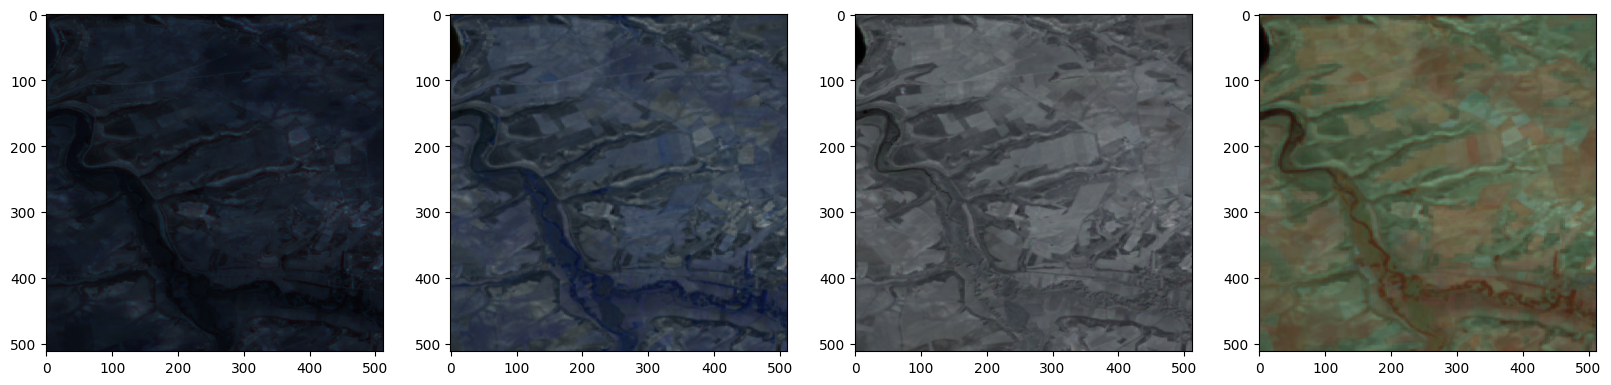

In [11]:
# try opening an image and displaying channels 0, 1, 2, and 3, 4, 5
img_num = 5
print(get_label(all_images[img_num]))

input_image = open_img(all_images[img_num])
print(input_image.size())

# Create a subplot with 1 row and 4 columns
plt.figure(figsize=(20, 5))

# Display the first channel in the first subplot
plt.subplot(1, 4, 1)
show_tensor(input_image, first_channel=0)

# Display the fourth channel in the second subplot
plt.subplot(1, 4, 2)
show_tensor(input_image, first_channel=3)

# Display the seventh channel in the third subplot
plt.subplot(1, 4, 3)
show_tensor(input_image, first_channel=6)

# Display the tenth channel in the fourth subplot
plt.subplot(1, 4, 4)
show_tensor(input_image, first_channel=9)

plt.show()


### Deep Dive into Data Augmentation. 🔄

#### The Problem 2 ❓

Data augmentation is a technique used in deep learning to increase the size of the training dataset by applying various transformations to the original images. This can help to reduce overfitting and improve the generalization performance of the model.

For image data, data augmentation techniques include rotation, scaling, flipping, cropping, and changing the brightness, contrast, and hue of the images etc. By applying these transformations to the training data, the model can learn to recognize objects and patterns from a wider range of perspectives and lighting conditions.

Data augmentation can be implemented using various libraries and frameworks, **Unfortunately, FastAI's built-in image augmentations expect 3 channels, so we need a work around.**

For this tutorial, I'm using a popular library called **Albumentations**. It has functions that also work with multispectral imagery. Below is the augmentation list I have chosen; feel free to add more if you want to. 🚀🎨


In [12]:
import albumentations as A

transform_list = [
    A.RandomBrightnessContrast(p=0.8, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
    A.Rotate(limit=10, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Blur(blur_limit=3, p=0.1),
    A.OneOf([
        A.IAASharpen(),
        A.IAAEmboss(),
        A.RandomBrightnessContrast(),
    ], p=0.3),
]


Below is a custom function called **aug_tfm function**, designed to apply augmentations to input tensors, assumed to be images (in our case 12 channels).

What it simply does:

1. **Input Check:**
   - Determines whether the input tensor represents an image or a label based on its element count.

2. **Reshaping for Albumentations:**
   - Converts the input tensor to a NumPy array and reshapes it to the format expected by the Albumentations library (H x W x C).

3. **Applying Augmentations:**
   - Iterates over a list of transformations (transform_list) and applies each transformation to the NumPy array.


In [13]:
# apply the augmentations in a loop
def aug_tfm(tensor):
#     this function is used for both images and labels so check the count of the input tensor
#     if the count is above 1 its not a label so apply the augmentations
    if tensor.nelement()>1:
#         convert tensor into numpy array and reshape it for Albumentations
        np_array = np.array(tensor.permute(1,2,0))
#        apply each augmentation
        for transform in transform_list:
            np_array = transform(image=np_array)['image']
#         some augmentations may shift the values outside of 0-1 so clip them  
        np_array = np.clip(np_array, 0, 1)
#        rearrange image to tensor format
        array_arange = np_array.transpose(2,0,1)
#        convert back to tensor
        tensor = torch.from_numpy(array_arange)

    return tensor

Let's see what the augmentations look like. 🔄🔍

In [14]:
multi_tfm = RandTransform(enc=aug_tfm, p=1)

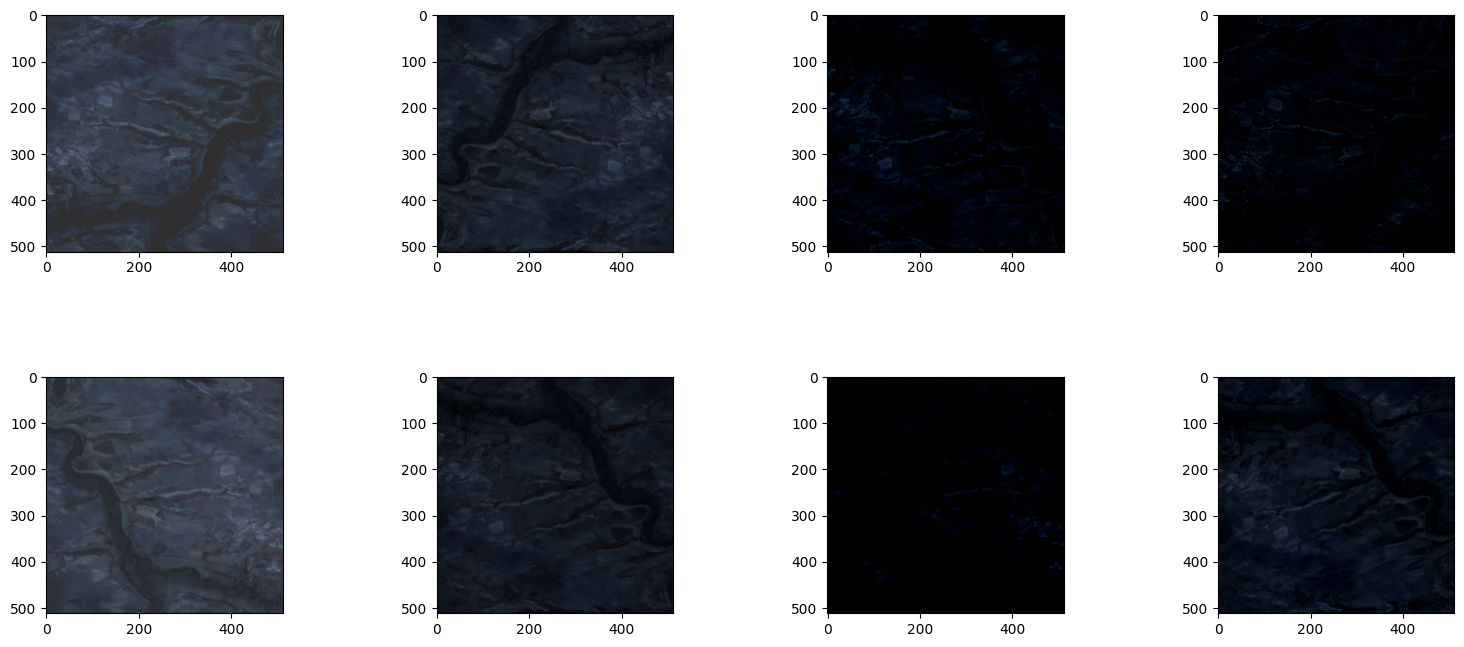

In [15]:
aug_test = open_img(all_images[5])
rows = 2
cols = 4
axes=[]
fig=plt.figure()

for a in range(rows*cols):
    b = tensor_to_np_3b(aug_tfm(aug_test))
    axes.append( fig.add_subplot(rows, cols, a+1) )
    plt.imshow(b)
fig.tight_layout()
fig.set_size_inches(cols*4, rows*4)
plt.show()

### Finalizing the Data Block 🧱🔗

The splitter simply splits your train set into train and validation. Fastai is very keen on overfitting and validation; even if you don't set the splitter, it does that automatically for you using defaults. Personally, I prefer the Train_test splitter. It helps me take advantage of the stratification, unlike random splits.

_In case you are wondering, stratification means we are able to split based on class or label._

Next, you'll have to tell the API how to fetch the address of the images and the respective label for that image. Remember that I've put all these stuff in a nice dataframe.

When you are done, create an instance of the datablock called the dataloader (dl). 🔄📤

###### Adding the File Path to the Filename 📂➕

I'm adding the file path to the filename so I can point it to the datablock.

In [16]:
train_df["filename"] = [f"{datapath}/train/train/"+i for i in train_df["filename"]]

In [17]:
train_df.head()

,filename,classes
0,/kaggle/input/finding-mining-sites/train/train/train_0.tif,0
1,/kaggle/input/finding-mining-sites/train/train/train_1.tif,0
2,/kaggle/input/finding-mining-sites/train/train/train_2.tif,0
3,/kaggle/input/finding-mining-sites/train/train/train_3.tif,1
4,/kaggle/input/finding-mining-sites/train/train/train_4.tif,0


In [18]:
db = DataBlock(blocks=(TransformBlock(open_img), CategoryBlock),
                   get_x = ColReader("filename"),
               get_y= ColReader("classes"),
               splitter=TrainTestSplitter(0.1, stratify=train_df["classes"]),
               item_tfms=multi_tfm,
                             )
dl = db.dataloaders(train_df, bs=bs)
batch = dl.one_batch()


###### See What the Shape of One Batch Looks Like 📊

There are 12 channels. 🎨

In [19]:
print(batch[0].shape, batch[1])

torch.Size([10, 12, 512, 512]) TensorCategory([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')


In [20]:
channel_count= batch[0].shape[1]
print('Channel count =',channel_count)

Channel count = 12


### Visualizing the Dataset 👀📸

When you create the data loader called dl, the splitter function splits it into train and validation, so you can see the contents of the train & validation batch if you want. Transformations are usually not done on the validation batch but they are done on the train batch. 🔄🚀

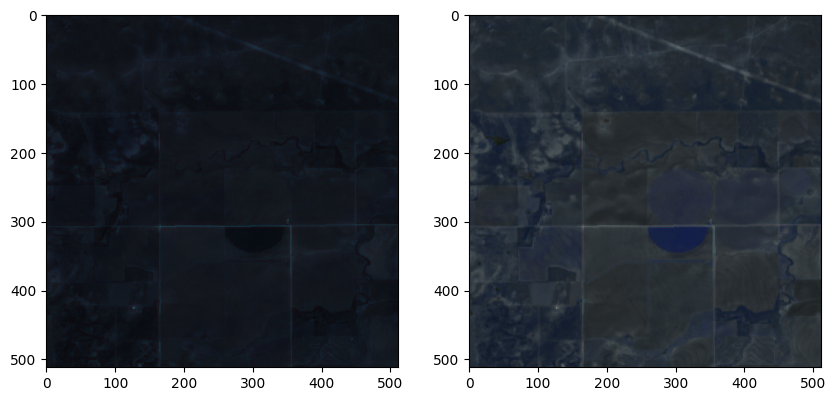

In [21]:
# grab a validation tensor, place it on the CPU then show it, this should not have augmentations
# first image is channels 0, 1, 2; second is 3, 4, 5
valid_tensor = dl.valid.one_batch()[0][2].cpu()

# Create a subplot with 1 row and 2 columns
plt.figure(figsize=(10, 5))

# Display the first channel of the first tensor in the first subplot
plt.subplot(1, 2, 1)
show_tensor(valid_tensor, first_channel=0)

# Display the first channel of the second tensor in the second subplot
plt.subplot(1, 2, 2)
show_tensor(valid_tensor, first_channel=3)

plt.show()

###### Visualizing the Training Batch 🖼️🚀

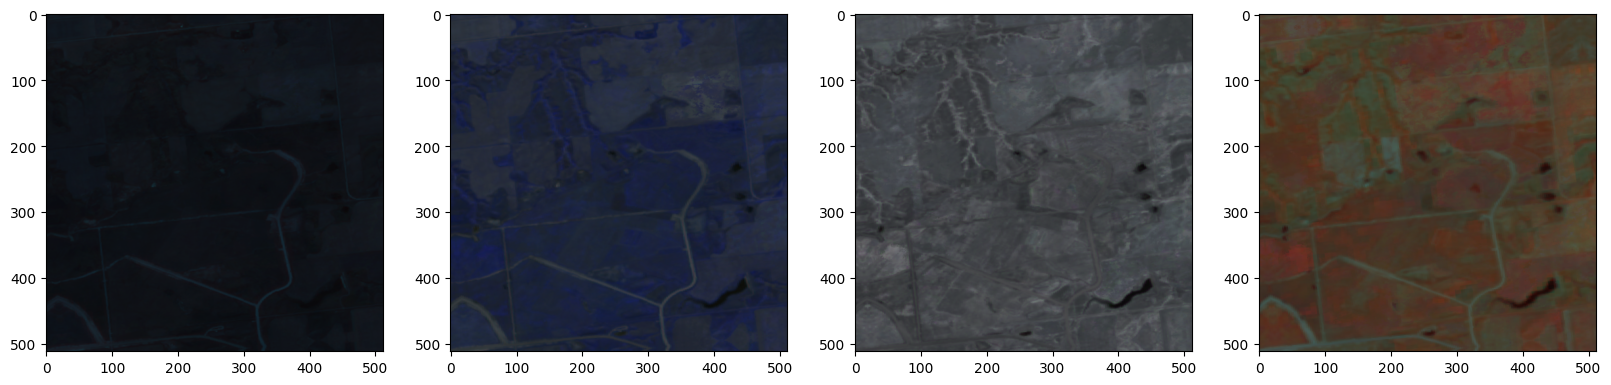

In [22]:
# show one tensor from the training set with augmentations
# first image is channels 0, 1, 2; second is 3, 4, 5; third is 6, 7, 8; fourth is 9, 10, 11
train_tensor = dl.train.one_batch()[0][5].cpu()

# Create a subplot with 1 row and 4 columns
plt.figure(figsize=(20, 5))

# Display the first channel of the first tensor in the first subplot
plt.subplot(1, 4, 1)
show_tensor(train_tensor, first_channel=0)

# Display the first channel of the second tensor in the second subplot
plt.subplot(1, 4, 2)
show_tensor(train_tensor, first_channel=3)

# Display the first channel of the third tensor in the third subplot
plt.subplot(1, 4, 3)
show_tensor(train_tensor, first_channel=6)

# Display the first channel of the fourth tensor in the fourth subplot
plt.subplot(1, 4, 4)
show_tensor(train_tensor, first_channel=9)

plt.show()


#### Explore Timm 🕵️‍♂️

You can list the available models in the Timm library using the `list_models()` function. This function is provided by the Timm library and can be used to generate a list of all the available model names. You can also filter models by passing a wild card filter. For instance, `res*` returns all the models that start with "res". 📚🔍

In [23]:
import timm
timm.list_models('vit_base*')

['vit_base_patch8_224',
 'vit_base_patch14_dinov2',
 'vit_base_patch14_reg4_dinov2',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_384',
 'vit_base_patch16_clip_224',
 'vit_base_patch16_clip_384',
 'vit_base_patch16_clip_quickgelu_224',
 'vit_base_patch16_gap_224',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_reg8_gap_256',
 'vit_base_patch16_rpn_224',
 'vit_base_patch16_siglip_224',
 'vit_base_patch16_siglip_256',
 'vit_base_patch16_siglip_384',
 'vit_base_patch16_siglip_512',
 'vit_base_patch16_xp_224',
 'vit_base_patch32_224',
 'vit_base_patch32_384',
 'vit_base_patch32_clip_224',
 'vit_base_patch32_clip_256',
 'vit_base_patch32_clip_384',
 'vit_base_patch32_clip_448',
 'vit_base_patch32_clip_quickgelu_224',
 'vit_base_patch32_plus_256',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50d_224']

# Time for Training! 🚀

Now it's time to train a model. We're going to take advantage of transfer learning and start with a nice pretrained model. There are many to choose from as listed above in the [timm library](https://github.com/huggingface/pytorch-image-models). Here, we'll use a `vit_base_patch16_siglip_512`.

There are fancier models that might take longer to train but can give better accuracy.

If you want to know which models are the best, check out this notebook from Jeremy Howard, the founder of FastAI. [Which Image Models are Best?](https://www.kaggle.com/code/jhoward/which-image-models-are-best/)

Although, we'll be doing something special which is `n_in=channel_count` that passes in the number of channels so FastAI can initialize random weights for the first layer too. Also, we use `fp16()` which just simply allows us to train with lower precision and preserve memory.

Creating a 'learner' with our chosen model architecture is as simple as:
```python
learn = vision_learner(dl, vit_base_patch16_512, metrics=[accuracy]).to_fp16()


In [24]:
learn = vision_learner(dl, "vit_base_patch16_siglip_512", n_in=channel_count, pretrained=True, metrics=[accuracy]).to_fp16()

open_clip_model.safetensors:   0%|          | 0.00/815M [00:00<?, ?B/s]

We've passed in accuracy as a metric out of interest. The 'F1Score' displayed during training is the validation F1Score and should closely match your score on Solafune.

We could start training, but first let's check out what changing the learning rate looks like. 📈🚦

SuggestedLRs(valley=0.00363078061491251)

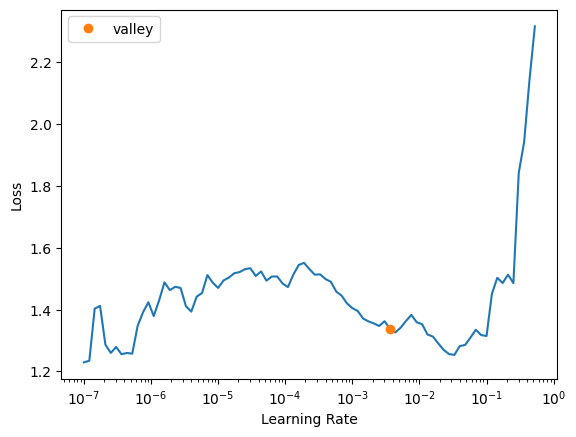

In [25]:
learn.lr_find()

In [26]:
learn.fit_flat_cos(20, cbs= [SaveModelCallback(monitor='valid_loss'),EarlyStoppingCallback(patience=5)])

epoch,train_loss,valid_loss,accuracy,time
0,0.778343,0.433929,0.864000,01:59
1,0.571520,0.394923,0.840000,01:55
2,0.458727,0.304129,0.864000,01:55
3,0.404462,0.297125,0.864000,01:55
4,0.390079,0.291363,0.872000,01:55
5,0.365879,0.268021,0.896000,01:55
6,0.321125,0.262566,0.888000,01:55
7,0.329165,0.273663,0.888000,01:55
8,0.299180,0.261417,0.880000,01:55
9,0.277837,0.300150,0.872000,01:56


Better model found at epoch 0 with valid_loss value: 0.433928906917572.
Better model found at epoch 1 with valid_loss value: 0.39492252469062805.
Better model found at epoch 2 with valid_loss value: 0.30412906408309937.
Better model found at epoch 3 with valid_loss value: 0.29712480306625366.
Better model found at epoch 4 with valid_loss value: 0.2913631200790405.
Better model found at epoch 5 with valid_loss value: 0.26802074909210205.
Better model found at epoch 6 with valid_loss value: 0.2625660300254822.
Better model found at epoch 8 with valid_loss value: 0.2614167034626007.
Better model found at epoch 10 with valid_loss value: 0.22735226154327393.
Better model found at epoch 12 with valid_loss value: 0.2212260663509369.
Better model found at epoch 16 with valid_loss value: 0.2135011851787567.
Better model found at epoch 17 with valid_loss value: 0.19125856459140778.
Better model found at epoch 18 with valid_loss value: 0.17799799144268036.


We're already at 93+% accuracy! Amazing. 🌟

In FastAI, We have various fit methods, `learner.fine_tune()`, `learner.fit_one_cycle()`, `learner.fit_flat_cos()`, etc.

The `fine_tune()` method in the fastai library is used for transfer learning. It allows you to fine-tune a pre-trained model on your specific task or dataset. It takes care of setting appropriate learning rates and training the model for a few epochs, gradually unfreezing layers for better performance.

The `fit_one_cycle()` method is used for training a model with the "1cycle" learning rate policy. This policy involves gradually increasing the learning rate, reaching a maximum, and then gradually decreasing it. This helps in faster convergence and potentially better generalization.

The `fit_flat_cos()` method in fastai is used for training a model with a flat cosine annealing learning rate schedule. This involves training the model with a flat learning rate for some epochs and then annealing it using a cosine function.

In this tutorial, I used the `fit_flat_cos()` method.

You can read more on the [docs](https://docs.fast.ai/tutorial.vision.html). 📚🚀


###### Check the Confusion Matrix 📊🔍

A confusion matrix is a useful tool for evaluating the performance of a classification model, as it provides more detailed information than a simple accuracy score. It can help identify classes where the model is making more errors, such as misclassifying one class as another.

In FastAI, you can generate a confusion matrix for a trained model using the `interp.plot_confusion_matrix()` method. This method takes the validation dataset as input and generates a graphical representation of the confusion matrix. 


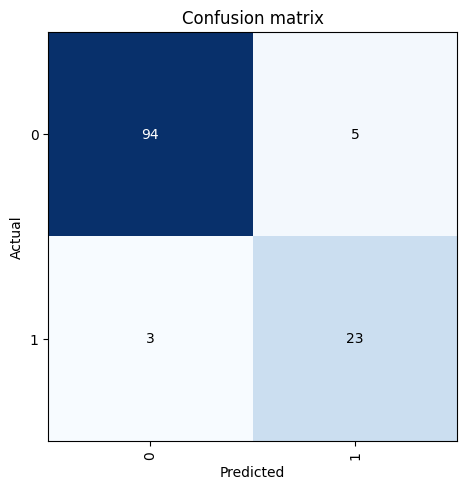

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

## Making Predictions 🤖🔮

The sample submission file lists the test images and shows a target column of all 0s. We want to replace those 0s with our predicted targets - close to 1 for Mining Sites, close to 0 for no Mining Sites detected.

In [28]:
ss = pd.read_csv(f"{datapath}/uploadsample.csv", names=["filename", "classes"])
ss["filename"] = [f"{datapath}/evaluation_images/"+i for i in ss.filename]
ss.head()

,filename,classes
0,/kaggle/input/finding-mining-sites/evaluation_images/evaluation_0.tif,0
1,/kaggle/input/finding-mining-sites/evaluation_images/evaluation_1.tif,0
2,/kaggle/input/finding-mining-sites/evaluation_images/evaluation_2.tif,0
3,/kaggle/input/finding-mining-sites/evaluation_images/evaluation_3.tif,0
4,/kaggle/input/finding-mining-sites/evaluation_images/evaluation_4.tif,0


Pass the CSV file to the dataloader as a test set. 📊

In [29]:
tdl = dl.test_dl(ss)

Conventionally, you could just do `learn.get_preds(dl=tdl)` to get the predictions, but I usually prefer using TTA. It takes longer, since it's making predictions on more variations of each test image. But TTA usually gives a better score. This means that the dataloader augments the test image in 15 different ways, performs inference, and then averages it. Did it work for you? Let me know 😉🔄📊

In [30]:
test_preds_, test_labels_tta = learn.tta(dl=tdl, n=5) #Get Predictions

In [31]:
# What do the predictions look like?
test_preds_[0] # The first prediction

tensor([0.9771, 0.0229])

#### Making Your Submission! 📤

A CSV file will be created called `Baseline.csv`, that is the file you will submit on Solafune. 📊📤

In [32]:
submission = ss = pd.read_csv(f"{datapath}/uploadsample.csv", names=["filename", "classes"])
submission.head()

,filename,classes
0,evaluation_0.tif,0
1,evaluation_1.tif,0
2,evaluation_2.tif,0
3,evaluation_3.tif,0
4,evaluation_4.tif,0


In [33]:
class_list = learn.dls.vocab
class_indexes = np.argmax(test_preds_, axis=1)
classes = [class_list[idx] for idx in class_indexes]

In [34]:
submission['classes'] = classes
submission.head()

,filename,classes
0,evaluation_0.tif,0
1,evaluation_1.tif,0
2,evaluation_2.tif,0
3,evaluation_3.tif,0
4,evaluation_4.tif,1


In [35]:
submission.to_csv("Baseline.csv",header=None,index=False)

Just a personal habit of mine, I like to peak and compare label distribution of the train and the submission. 📊🔍

In [36]:
submission['classes'].value_counts()

classes
0    1021
1     222
Name: count, dtype: int64

In [37]:
train_df['classes'].value_counts()

classes
0    986
1    256
Name: count, dtype: int64

## What Next? 🤔

I hope you had fun! This starter notebook provides a solid foundation, but there's room for significant improvement. By implementing some advanced techniques, you can elevate your model's performance beyond the initial score with some more effort. Here are some ideas to enhance your approach:

###### 1. Experiment with Advanced Models
Explore more sophisticated and powerful models. Dive into other state-of-the-art models or architectures. These models may offer better performance and capture complex patterns in the data.

###### 2. Optimize Data Augmentation
Revisit the data augmentation step and enhance it further. Improved data augmentation can boost the model's ability to generalize and recognize patterns. Experiment with different augmentation techniques to find the optimal combination.

###### 3. Data Cleaning and Exploration
Invest time in data exploration and cleaning. A thorough understanding of the data can uncover valuable insights. Identify outliers, anomalies, or mis-labeled data, and apply appropriate strategies to handle them. Remember, good data leads to good models.

###### 4. Utilize Specialized Pretrained Models
Consider using pretrained models specifically designed for satellite image classification. Check out the leaderboard on Papers with Code for the latest and most effective models. Microsoft's TorchGeo library is a valuable resource worth exploring too.

- Papers with Code Leaderboard: [Satellite Image Classification](https://paperswithcode.com/task/satellite-image-classification)
- Microsoft TorchGeo Library: [GitHub - TorchGeo](https://github.com/microsoft/torchgeo)

###### 5. Experiment with Different Loss Functions
Modify the loss function from the FastAI default to better suit the characteristics of your data. Choosing an appropriate loss function can have a significant impact on the model's performance.

###### 6. Implement K-Fold Cross-Validation
Enhance the robustness of your model by adopting a K-Fold cross-validation strategy. This approach provides a more reliable estimate of your model's performance and ensures better generalization.

###### 7. Ensemble Multiple Models
Combine predictions from multiple models by creating an ensemble. Ensemble methods, such as taking the mode of different model submissions, can lead to improved performance and increased stability.

Feel free to experiment with these suggestions and iterate on your approach. Good luck, and enjoy the challenge! See You on the leaderboard. 🚀🏆

### The End

I am always open to assist enthusiasts with difficulties they are facing in Machine learning and Deep learning journey. Feel free to reach out to me: most preferably LinkedIn.

- [Twitter](https://twitter.com/olufemivictort).

- [Linkedin](https://www.linkedin.com/in/olufemi-victor-tolulope).

- [Github](https://github.com/osinkolu)

### Author: Olufemi Victor Tolulope